# CausalML Lecture 5: Heterogeneus Treatment Effect

"The average causal effect T is an _average_ and as such enjoys all the advantages and disadvantages of averages." – P. W. Holland

**Giorgio Coppola**  
**Xiaohan Wu**

---

## Setup Instructions

To replicate this environment and run this notebook with the exact same package versions using poetry like in Lecture 1:

1. **Install dependencies**:
   ```bash
   poetry install
   ```
   This will create a virtual environment and install all dependencies specified in `pyproject.toml`. Learn more about [dependency management](https://python-poetry.org/docs/dependency-specification/).

2. **Create and install the Jupyter kernel**:
   ```bash
   poetry run python -m ipykernel install --user --name=lecture-5-env --display-name="CausalML Lecture 5"
   ```
   The `poetry run` command executes commands within the Poetry virtual environment. See [Poetry environment management](https://python-poetry.org/docs/managing-environments/).

3. **Start Jupyter**:
   ```bash
   poetry run jupyter notebook
   ```

4. **Select the kernel**: In Jupyter, go to Kernel → Change Kernel → "CausalML Lecture 5"

For more information about Poetry and its features, visit the [official Poetry documentation](https://python-poetry.org/docs/).

---

## Quick recap form Lecture 5 and previous  

#### Until now, we **focused on the ATE** in experimental or nonrandomized observational settings, using **global information!**  

For this, **modeling (including ML) helps:** we can adjust for pre-treatment covariates, balance with weights, or do both. These approaches help because they **exploit covariates information to approximate missing counterfactuals** and to implement the assumption of conditional ignorability when it’s plausible.  

- In **experimental settings,** ignorability holds by design; covariate adjustment mainly improves precision (and can mitigate sample imbalance and noncompliance), while weighting rebalances covariates to address observed selection bias when randomization fails (if we have overlap). Doubly robust estimators combine outcome and treatment models and are consistent if either is correctly specified.  

- In **observational settings,** identification relies on **conditional ignorability** given selected pre-treatment covariates (plus overlap and SUTVA). Models and weights (or both), if they are correctly specified, can help replace the assumption of independence with a less stringent conditional version, yielding to a consistent ATE.  

#### **With HTE, this is harder:** we need local information, but **local information is scarce!**   

We want to estimate a **causal effect that vary across units**. Problem: we cannot make causal claims about specific individuals with certainty!  

When estimating HTE, we are interested in **ITE or CATE conditional on groups defined by X**. We cannot estimate ITE, but CATE is a compromise. However, as X-defined groups get finer, we can lose overlap locally, we don't have sufficient treatment and control units for each X-defined groups &rarr; **curse of dimensionality**.

As **we don't have an observable target** (counterfactual), we don't have a natural loss function and a validation set. This means that the HTE true signal that an estimator can estimate is small relative to the noise, and naïve ML approaches like "T-learners" or "S-learners" are prone to high variance/overfitting. They usually mistake prognostic signal (features that predict baseline risk) and treatment assignment signal (propensity) for causal moderation (the features that change how much treatment effect vary): you might highlight **spurious heterogeneity**.

The challenge is **recover CATEs without chasing noise** and report uncertainty that’s credible. 
To do so, we need methods that build a valid loss with orthogonal/pseudo-outcomes and cross-fitting like 
- **causal forests**,
- **X-learners**, and
- **DR-learners**,  

so we can target CATE τ(x), rather than modeling the outcome Y alone.  

We are going to show some of them, and how they can help!

---


# Simulation Plan: HTE Estimation

## Aims  

Show, via a Monte Carlo simulation, that:  

1. **Naïve ML for HTE (S/T-learners)** mostly learns prognosis or amplifies noise.   
2. **Causal Forests** (Wager–Athey, 2018) recover heterogeneity and enable inference when overlap is decent.  
3. **Meta-learners (X-learner; DR-learner)** (Künzel et al., 2019; Kennedy, 2020) recover heterogeneity also with imbalance.  

---

## Data Generating Mechanism  

We simulate two scenarios:  

- **Balanced treatment assignment** across covariates $X$.  
- **Imbalanced assignment** to make things **worse** for naïve learners!

**Setup:**  

- **Covariates:** Ten features give enough richness for prognosis and treatment effect to depend on different things
  $$
  X = (X_1, \dots, X_{10}) \sim \mathcal{N}(0,1).
  $$  
- **Potential outcomes** with some noise: 
  $$
  Y(0) = \mu(X) + \varepsilon, \quad 
  Y(1) = \mu(X) + \tau(X) + \varepsilon, \quad 
  \varepsilon \sim \mathcal{N}(0,1).
  $$  
- **Baseline outcome (prognosis):** We add nonlinearities & interactions.  
  If $\mu(X)$ (prognosis) is large/complex and $\tau(X)$ is modest, the best way to reduce squared error is to learn $\mu(X)$ very well. This is what naïve learners do: nothing in the loss forces them to isolate $\tau(X)$.
  $$
  \mu(x) = 2\sin(X_1) + 1.25X_2 + 1.5\mathbf{1}\{X_3>0\} + 0.75X_4X_5 + |X_6|
  $$  
- **True treatment effect (CATE):** We add moderation.  
  $\tau$ depends partly on the same variables as $\mu$ (e.g., $X1$,$X3$) but not in the same way, and also on regions of $X2$. This creates moderation.
  $$
  \tau(x) = 1 + 0.8\mathbf{1}\{X_1>0\} - 0.8\mathbf{1}\{X_2>1\} + \sin(X_3/2), \quad 
  \tau(x) \in [-2.5, 2.5].
  $$  
- **Treatment assignment:**  
  - *Balanced:* propensities near 0.5 with little X-dependence.  
    $$
    e(x) = \sigma(0.1X_1 - 0.1X_2 + 0.1X_7)
    $$  
  - *Imbalanced:* units have high or low propensities.
That creates regions with few controls or few treated, and it's useful to show the limitation and streght of methods.
    $$
    e(x) = \sigma(-1 + 1.0X_1 + 0.8X_2 + 0.5X_7)
    $$  
  - $ A \sim \text{Bernoulli}(e(x)) $.  

---

## Assumptions  

- **Conditional ignorability:**  $Y(a) \perp A \mid X$  
- **Overlap:**  $0 < P(A=1 \mid X) < 1$  
- **SUTVA:** Stable unit treatment values, no interference.  

---

## Estimands  

- **CATE:** $ \tau(x) $ evaluated on test set.  
- **ATE:** $ \mathbb{E}[\tau(X)] $ to check if our CATE $ \tau(x) $ integrates to the right average effect.

---

## Methods  

**Baselines (expected to fail):**  
- **S-learner:** one outcome model $ m(a,x) $, $ \tau(x) = m(1,x) − m(0,x)$.  
- **T-learner:** separate outcome models by arm, subtract predictions.  

**Solutions:**  
- **Causal Forest** (Wager–Athey, 2018).  
- **X-learner** (Künzel et al., 2019) with tree base models.  
- _(If we manage)_ **DR-learner** (Kennedy, 2020).  

---

## Performance Metrics  

- **CATE estimation error (MSE):** Measures how close our predicted CATEs are to the true CATEs pointwise  
  $$
  \text{MSE} = \mathbb{E}\left[(\hat{\tau}(x) - \tau(x))^2\right]
  $$
  
- **ATE recovery:** compare $ \hat{\text{ATE}} = \mathbb{E}[\hat{\tau}(x)] $ vs. true ATE.
  Even if pointwise CATEs are noisy, a good method should still get the average effect right. If $\hat{ATE}$ is far from $ATE_{True}$ , the model is systematically biased.
  
- **Scatter plot:** compare $\hat{\tau}(x)$ vs. true $\tau(x)$.

- _(If we manage)_ **Calibration plots:**  
Do high predicted CATEs correspond to actually larger realized effects?    
  - Bin units by predicted CATE ($\hat{\tau}(x)$).  
  - X-axis = average predicted CATE in bin.  
  - Y-axis = realized treatment effect in bin.
     
---

## Simulation

We will simulate data and test methods under condition different conditions. 

### Expected Results

- **Balanced assignment:** S/T-learners capture prognosis, not treatment effect; poor calibration. Causal Forest and X-learner align more closely with true CATE.  
- **Imbalanced assignment:** S/T degrade further (follow propensity & prognosis). Causal Forest performs well when overlap exists but fails in low-overlap pockets; X-learner helps under imbalance.  
- **Key lesson:** Without orthogonalization and overlap, naïve ML misleads us about heterogeneity.  

### Setup environment


In [24]:
import numpy as np
import pandas as pd
import plotnine as p9
from plotnine import (
    ggplot, aes, geom_histogram, geom_density, geom_point, geom_line,
    geom_vline, labs, theme_minimal
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from econml.metalearners import XLearner
from econml.dml import CausalForestDML

p9.theme_set(theme_minimal() + theme(legend_position="bottom"))
np.random.seed(12345)

## Data Generation for HTE 


In [59]:

# helper
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# defining the true parameter
def mu_func(X):
    """
    Baseline prognosis μ(x) with nonlinearities & interactions:
    μ(x) = 2*sin(X1) + 1.25*X2 + 1.5*1{X3>0} + 0.75*X4*X5 + |X6|
    """
    x1, x2, x3, x4, x5, x6 = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4], X[:,5]
    return 2*np.sin(x1) + 1.25*x2 + 1.5*(x3 > 0).astype(float) + 0.75*x4*x5 + np.abs(x6)

def tau_func(X):
    """
    True CATE τ(x):
    τ(x) = 1 + 0.8*1{X1>0} - 0.8*1{X2>1} + sin(X3/2), clipped to [-2.5, 2.5]
    """
    x1, x2, x3 = X[:,0], X[:,1], X[:,2]
    tau = 1 + 0.8*(x1 > 0).astype(float) - 0.8*(x2 > 1).astype(float) + np.sin(x3/2)
    return np.clip(tau, -2.5, 2.5)

def propensity(X, scenario="balanced"):
    """
    Propensity e(x) = P(A=1|X)
      balanced:  e(x) = σ(0.1*X1 - 0.1*X2 + 0.1*X7)  ~ around 0.5, mild X-dependence
      imbalanced:e(x) = σ(-1 + 1.0*X1 + 0.8*X2 + 0.5*X7)  --> weaker overlap
    """
    x1, x2, x7 = X[:,0], X[:,1], X[:,6]
    if scenario == "balanced":
        logits = 0.1*x1 - 0.1*x2 + 0.1*x7
    elif scenario == "imbalanced":
        logits = -1 + 1.0*x1 + 0.8*x2 + 0.5*x7
    else:
        raise ValueError("scenario must be 'balanced' or 'imbalanced'")
    return sigmoid(logits)

# defining the population simulator 
def simulate_htedgp(n = 600, scenario = "balanced", noise_sd=1.0, seed=12345):
    """
    Draw X ~ N(0,1)^10, compute μ, τ, propensities e(X), treatment A ~ Bernoulli(e),
    and observed Y = μ + A*τ + ε with ε ~ N(0, noise_sd^2).
    Returns a DataFrame with X1..X10, mu_true, tau_true, e, A, eps, Y, y0_true, y1_true.
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, 10))
    mu = mu_func(X)
    tau = tau_func(X)
    e = propensity(X, scenario=scenario)
    A = rng.binomial(1, e, size=n)
    eps = rng.normal(0, noise_sd, size=n)
    Y = mu + A * tau + eps
    y0_true = mu
    y1_true = mu + tau

    df = pd.DataFrame({f"X{j+1}": X[:, j] for j in range(10)})
    df["mu_true"] = mu
    df["tau_true"] = tau
    df["e_true"] = e
    df["A"] = A
    df["eps"] = eps
    df["Y"] = Y
    df["y0_true"] = y0_true
    df["y1_true"] = y1_true
    df["scenario"] = scenario
    df.attrs["true_ate"] = float(np.mean(tau))
    return df


## Exploration

### Properties of the population

We will first examine fixed properties of the population. Once we generate a population (for our simulation), these properties are not assumed to be "random" at all.

Let's define the size of our population, sample and treatment group as parameters which we can tinker with to see how it changes results.

In [60]:
# params
N = 6000
SCENARIO = "balanced"

df = simulate_htedgp(n=N, scenario=SCENARIO)

In [62]:
# properties
print("True ATE:", df.attrs["true_ate"])
print("P(A=1):", df["A"].mean())

# overlap diagnostic
good_overlap = df["e_true"].between(0.05, 0.95).mean()
print("Share with e(x) in [0.05,0.95]:", round(good_overlap, 3))


True ATE: 1.277749002387787
P(A=1): 0.5003333333333333
Share with e(x) in [0.05,0.95]: 1.0


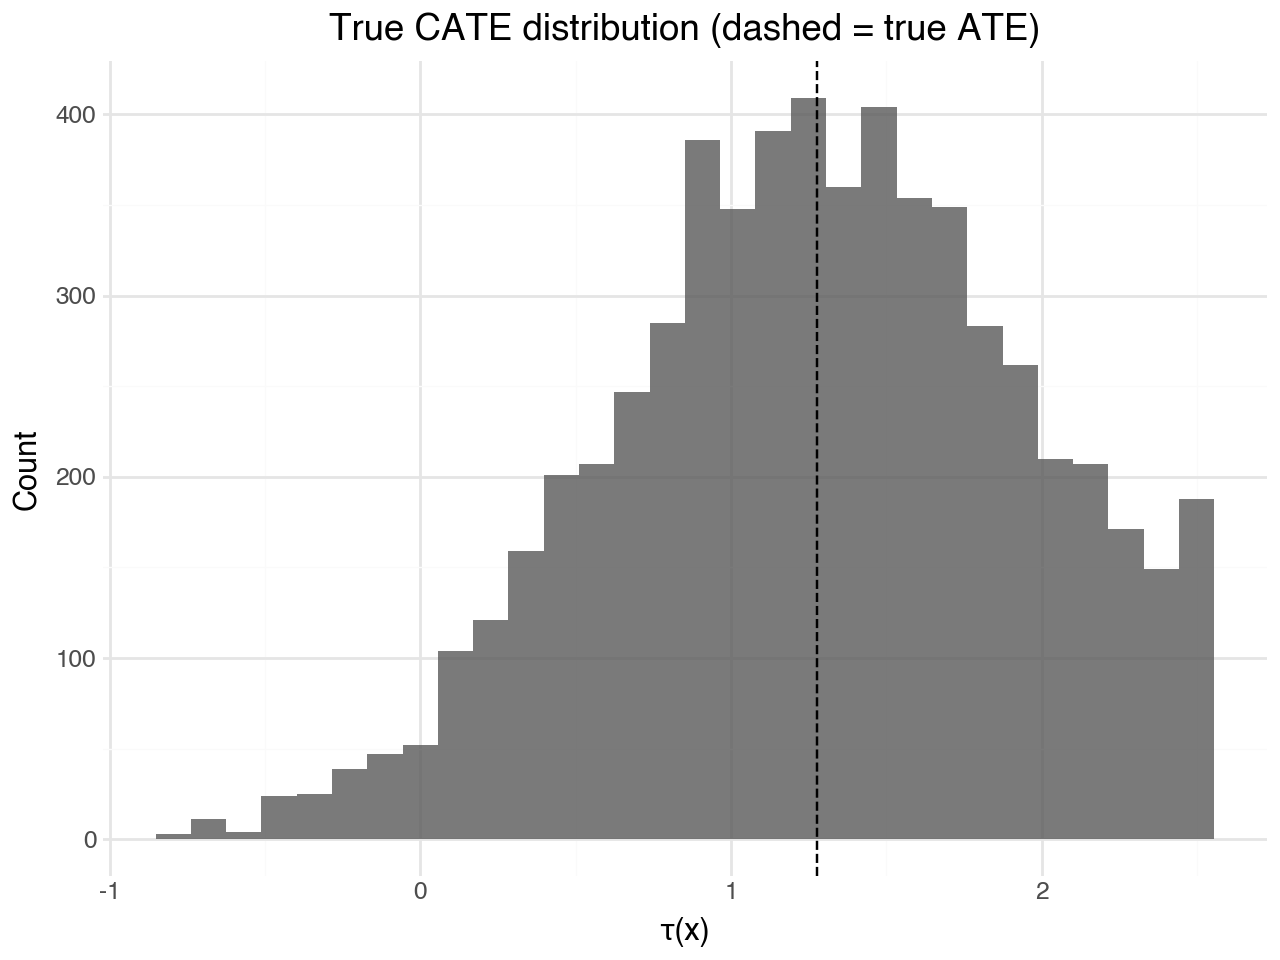

In [63]:
ATE = df.attrs.get("true_ate", float(df["tau_true"].mean()))

p_tau_dist = (
    ggplot(df, aes(x="tau_true"))
    + geom_histogram(bins=30, alpha=0.8)
    + geom_vline(xintercept=ATE, linetype="dashed")
    + labs(x="τ(x)", y="Count", title="True CATE distribution (dashed = true ATE)")
    + theme_minimal()
)
p_tau_dist


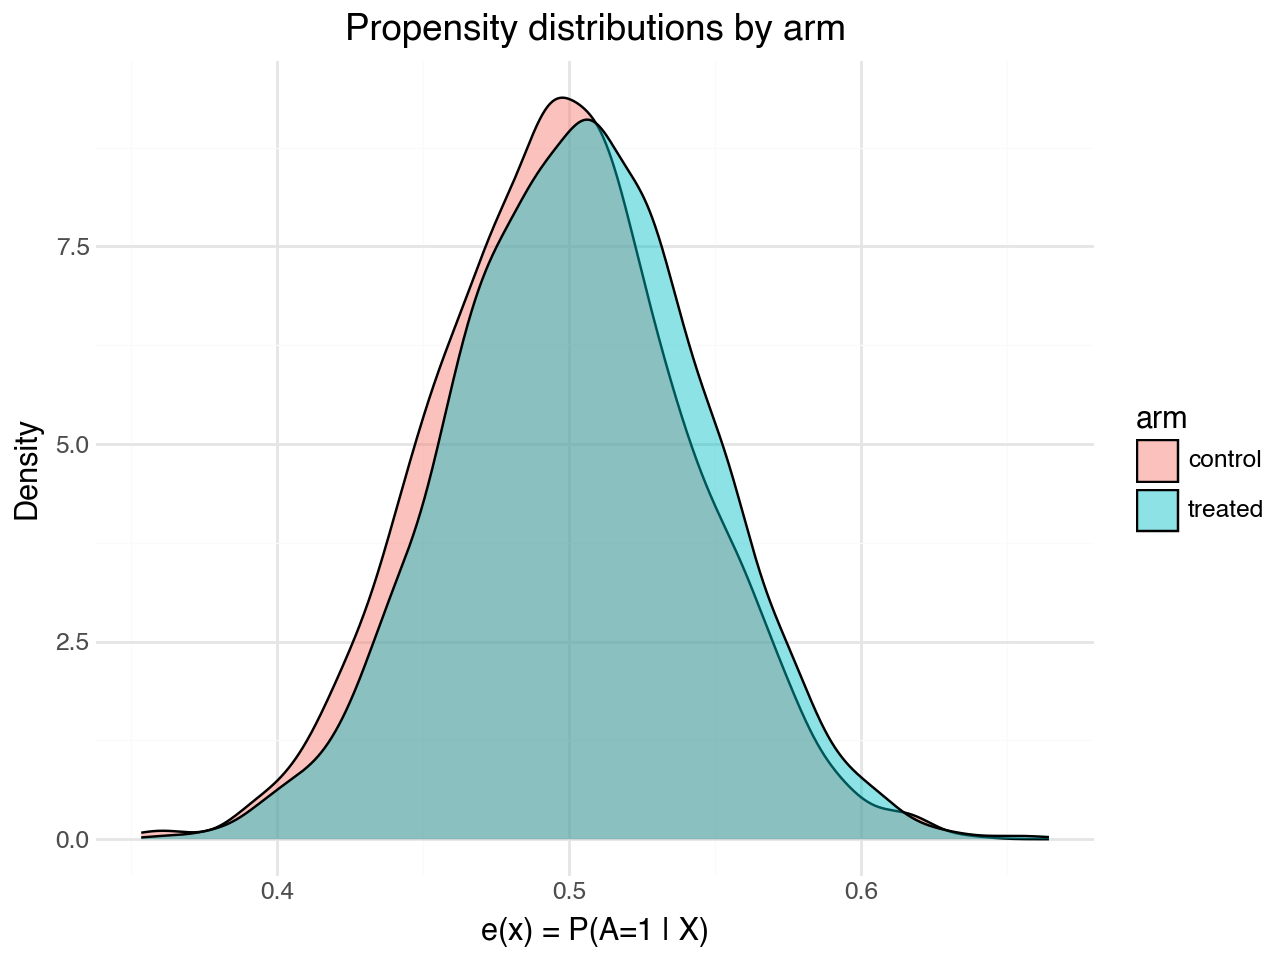

In [64]:
df_arm = df.assign(arm=np.where(df["A"]==1, "treated", "control"))
p_props = (
    ggplot(df_arm, aes(x="e_true", fill="arm"))
    + geom_density(alpha=0.45)
    + labs(x="e(x) = P(A=1 | X)", y="Density", title="Propensity distributions by arm")
    + theme_minimal()
)
p_props

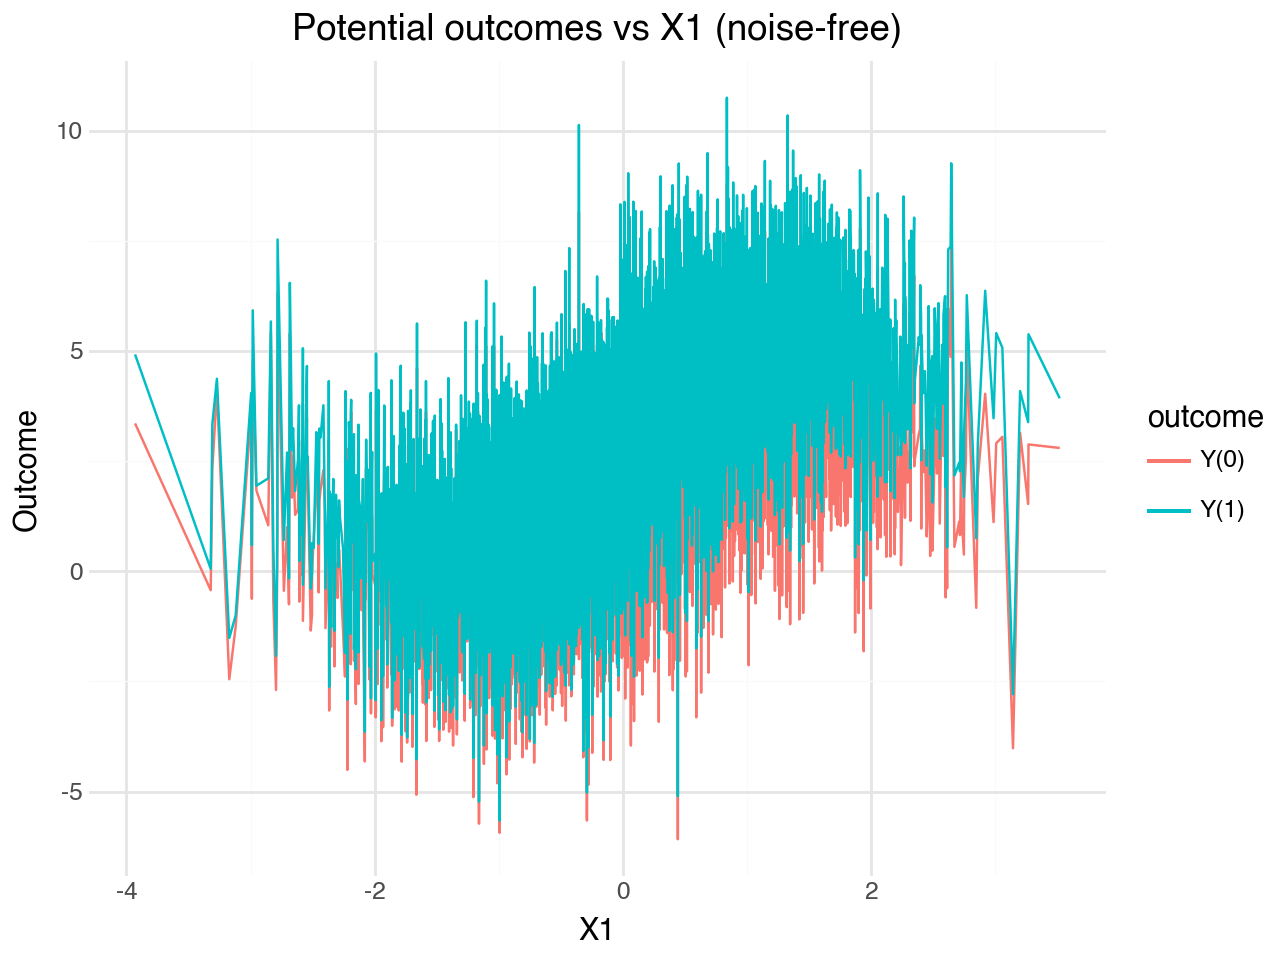

In [65]:
pot = df.loc[:, ["X1", "y0_true", "y1_true"]].sort_values("X1").rename(
    columns={"y0_true":"Y(0)", "y1_true":"Y(1)"}
)
pot_long = pot.melt(id_vars="X1", var_name="outcome", value_name="y")

p_pot = (
    ggplot(pot_long, aes(x="X1", y="y", color="outcome"))
    + geom_line()
    + labs(x="X1", y="Outcome", title="Potential outcomes vs X1 (noise-free)")
    + theme_minimal()
)
p_pot